# **Deep Learning Project: Garbage Classification - Modelization in 128x128 size**

My approach to model creation involved dividing my work into several notebooks, each dedicated to specific types of data and models. I had one notebook for pre-trained models, and two for custom models—one for 50x50 pixel size images and another for 128x128. I then consolidated the top-performing models from each category into a notebook named 'Best Models.' Finally, I conducted a manual grid search in a separate notebook to further optimize the best-performing models.

This particular notebook is dedicated to modeling for the 128x128 size images.

## 1. Import Libraries

In [2]:
import pandas as pd
import os
import numpy as np
import PIL
import cv2
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Metric

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

## 2. Load the splited data

In [4]:
def load_data_from_directory(directory):
    file_paths = []
    class_labels = []
    # Walk through the directory
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        # Make sure to ignore any non-directory entries
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                file_path = os.path.join(class_dir, filename)
                if filename.endswith('.jpg'):
                    file_paths.append(file_path)
                    class_labels.append(class_name)
    # Convert class labels to numeric
    unique_classes = np.unique(class_labels)
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(unique_classes)}
    numeric_labels = [class_to_idx[cls_name] for cls_name in class_labels]
    return file_paths, numeric_labels, class_to_idx

# Define directories
split_dir = "./resized and split 128/train_test_val_128/train_test_val_128"
train_dir = os.path.join(split_dir, 'train')
test_dir = os.path.join(split_dir, 'test')
val_dir = os.path.join(split_dir, 'validation')

# Load data
train_paths, train_labels, class_to_idx = load_data_from_directory(train_dir)
test_paths, test_labels, _ = load_data_from_directory(test_dir)
val_paths, val_labels, _ = load_data_from_directory(val_dir)

# Verify the data
print(f"Loaded {len(train_paths)} training samples.")
print(f"Loaded {len(test_paths)} testing samples.")
print(f"Loaded {len(val_paths)} validation samples.")

Loaded 12412 training samples.
Loaded 1241 testing samples.
Loaded 1862 validation samples.


## 3. Define the needed variables

In [4]:
img_size = (128,128)
# batch_size = 16
label_mode="categorical"

# Set random seed for NumPy
np.random.seed(42)
# Set random seed for TensorFlow
tf.random.set_seed(42)
# Set random seed for Python's built-in random module
random.seed(42)

## 4. Data Augmentation
I'm implementing data augmentation in the training dataset so that the model can see different images produced from the original one across epochs. I'm also resizing images down so that the pixel values range from 0 to 1.

When I create the train_generator using flow_from_dataframe, I'm not pre-generating all batches of images with their transformations. What I'm doing is setting up a framework or a "pipeline" that knows how to fetch and transform the images when requested.

The benefit of ImageDataGenerator is precisely this: it generates augmented images on-the-fly during each step of each epoch. It doesn't pre-generate and store them.

### 4.1 Data Augmentation V1

In [ ]:
train_datagen1 = ImageDataGenerator(rescale=1./255,
                                   rotation_range=180, 
                                   width_shift_range=0.25,
                                   height_shift_range=0.25, 
                                   shear_range=0.25, 
                                   zoom_range=0.25,
                                   horizontal_flip=True, 
                                   fill_mode='nearest')

print("Batch size : 16")

train_generator_16_1 = train_datagen1.flow_from_directory(train_dir, 
                                                      target_size=img_size,
                                                      batch_size=16, 
                                                      class_mode=label_mode)

# For validation no augmentation is applied, just rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

validation_generator_16 = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=16,
    class_mode=label_mode
)

Batch size : 16


Found 12412 images belonging to 12 classes.
Found 1862 images belonging to 12 classes.


### 4.2 Data Augmentation V2

In [6]:
print(f"Batch size : 16")
# Define the ImageDataGenerator for training with augmentation
train_datagen2 = ImageDataGenerator(
    rescale=1./255,          
    rotation_range=45,       
    width_shift_range=0.1,   
    height_shift_range=0.1,  
    shear_range=0.1,         
    zoom_range=0.2,          
    horizontal_flip=True,    
    brightness_range=[0.8, 1.2], 
    fill_mode='nearest'      
)


train_generator_16_2 = train_datagen2.flow_from_directory(
    train_dir,
    target_size=img_size,  
    batch_size=16, 
    class_mode=label_mode  
)

Batch size : 16
Found 12412 images belonging to 12 classes.


### 4.3 Example of an augmented Image with Data Augmentation V1

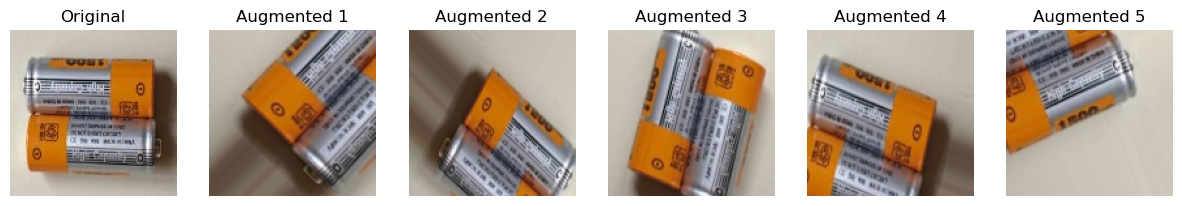

In [7]:
def plot_augmented_images(original, generator, num_images=5):
    # Plotting the original image
    fig, axes = plt.subplots(1, num_images+1, figsize=(15, 5))
    axes[0].imshow(original)
    axes[0].set_title('Original')
    axes[0].axis('off')

    # Plotting the augmented images
    for i in range(1, num_images+1):
        augmented_image = next(generator)[0]
        axes[i].imshow(augmented_image)
        axes[i].set_title(f'Augmented {i}')
        axes[i].axis('off')

    plt.show()

# Load an example image - adjust index as needed
example_image = cv2.imread(train_paths[0])
example_image = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
example_image_resized = cv2.resize(example_image, img_size)  # Resize and normalize

# Prepare the image for the generator (add batch dimension, as the generator expects batches)
example_image_batch = np.expand_dims(example_image_resized, axis=0)

# Create a temporary generator for this single image
temp_generator = train_datagen1.flow(
    example_image_batch,
    batch_size=1
)

# Plot the comparison for 5 augmented images
plot_augmented_images(example_image_resized, temp_generator)

## 5. Defining the input_shape

In [8]:
input_shape = example_image_resized.shape
input_shape

(128, 128, 3)

## 6. Weights
Compute class weights to address class imbalance, enhancing model performance in classification tasks.

In [9]:
# Calculate class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight = 'balanced',                            
    classes = np.unique(train_generator_16_1.classes),    # Unique classes in the training data
    y = train_generator_16_1.classes                      # Actual class labels of the training data
)

In [10]:
# Dictionary mapping class indices to their respective class weights
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 1.3681657848324515,
 1: 1.3126057529610828,
 2: 2.1326460481099656,
 3: 1.4506778868630201,
 4: 0.24280125195618155,
 5: 2.0563286944996686,
 6: 1.6818428184281842,
 7: 1.2313492063492064,
 8: 1.4947013487475915,
 9: 0.6538137378845343,
 10: 1.8536439665471924,
 11: 1.668279569892473}

## 7. Callbacks

In [11]:
# Directory to save model checkpoints
checkpoint_dir = "./Callbacks"
# Create the directory if doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

# Function to create callbacks for model training
def create_model_callbacks(model_name):
    # Create a directory specific to the model
    model_checkpoint_dir = os.path.join(checkpoint_dir, model_name)
    os.makedirs(model_checkpoint_dir, exist_ok=True)

    #  ModelCheckpoint callback to save the best model weights based on validation F1 score
    cp_callback_acc = ModelCheckpoint(
        filepath=os.path.join(model_checkpoint_dir, 'best_model_acc.h5'),
        save_best_only=True,
        save_weights_only=True,
        monitor='val_f1_score',
        mode='max',  # Maximize the F1 score
        verbose=1
    )

    # EarlyStopping callback to stop training if validation F1 score does not improve
    early_stopping_callback = EarlyStopping(
        monitor='val_f1_score',
        patience=5,
        mode='max', 
        verbose=1
    )

    # ReduceLROnPlateau callback to reduce learning rate if validation F1 score does not improve
    reduce_lr_callback = ReduceLROnPlateau(
        monitor='val_f1_score',
        factor=0.2,
        patience=2,
        mode='max',  
        verbose=1,
        min_lr=0.001
    )

    # List of callbacks to return
    return [cp_callback_acc, early_stopping_callback, reduce_lr_callback]

## 8. Defining functions to check model performance

In [12]:
# Define a custom F1Score metric class
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        # Initialize weights to track true positives, false positives, and false negatives
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    # Update state based on true labels and predicted labels
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.greater_equal(y_pred, 0.5) 
        true_positive = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
        false_positive = tf.logical_and(tf.equal(y_true, False), tf.equal(y_pred, True))
        false_negative = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, False))
        
        self.true_positives.assign_add(tf.reduce_sum(tf.cast(true_positive, self.dtype)))
        self.false_positives.assign_add(tf.reduce_sum(tf.cast(false_positive, self.dtype)))
        self.false_negatives.assign_add(tf.reduce_sum(tf.cast(false_negative, self.dtype)))

    # Calculate F1 score based on current state
    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    # Reset state to initial values
    def reset_states(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)

In [14]:
# Function to plot the F1 and Loss values for both train and validation
def plot_training_history(history):
    df_hist = pd.DataFrame.from_dict(history.history)
    df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

    fig, axs = plt.subplots(1, 2, figsize=(9, 4))

    # Plot loss curves
    ax1 = df_hist.plot(x="Epoch", y=['loss', 'val_loss'],
                       kind="line", grid=True, legend=True,
                       ylabel="Categorical cross-entropy", 
                       xlabel="Epoch", title="Loss curves",                  
                       color=['darkred', 'indianred'], alpha=0.75, fontsize=10, ax=axs[0])
    ax1.legend(loc=(0, -0.45), framealpha=1.0)
    ax1.set_ylim([0, 2])

    # Plot F1 score curves
    ax2 = df_hist.plot(x="Epoch", y=['f1_score', 'val_f1_score'],
                       kind="line", grid=True, legend=True,
                       ylabel="F1 Score", 
                       xlabel="Epoch", title="F1 Score curves",                  
                       color=['darkblue', 'royalblue','green'], alpha=0.75, fontsize=10, ax=axs[1])
    ax2.legend(loc=(0, -0.45), framealpha=1.0)
    ax2.set_ylim([0, 1])

In [15]:
# Function to extract accuracy, F1 Score, and loss, from a given training history based on a specified metric (F1 as default)
def get_metrics(rec, metric='f1_score'):
    # Find the index of the best validation accuracy
    index = np.argmax(rec.history[metric])
    
    # Extract scores based on the index
    acc = rec.history["accuracy"][index]
    f1 = rec.history["f1_score"][index]
    loss = rec.history["loss"][index]
    val_acc = rec.history["val_accuracy"][index]
    val_f1 = rec.history["val_f1_score"][index]
    val_loss = rec.history["val_loss"][index]

    return acc, f1, loss, val_acc, val_f1, val_loss


In [16]:
# Function to compile the model with Adam optimizer
def compile_model(model):
    # Compile the model with F1 score as a metric
    model.compile(optimizer = 'adam',
                loss='categorical_crossentropy',
                metrics=['accuracy', F1Score()])
    return model

## 9. Models

### 9.1 CNN Model

In [17]:
# Model definition
model0 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(3, 3),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),

    Dense(train_generator_16_1.num_classes, activation='softmax')
])

model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 9, 128)        0

#### 9.1.1 Compile the model with Data Augmentation V1

In [18]:
# Create callbacks for the model
callbacks = create_model_callbacks("history01")
model01 = compile_model(model0)

# Train the model with callbacks
history01 = model01.fit(
    train_generator_16_1,
    validation_data=validation_generator_16,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50


776/776 [==============================] - ETA: 0s - loss: 1.5518 - accuracy: 0.4860 - f1_score: 0.4100

c:\Users\Utilizador\anaconda3\envs\DL\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_f1_score improved from -inf to 0.53093, saving model to ./Callbacks\history01\best_model_acc.h5
776/776 [==============================] - 191s 242ms/step - loss: 1.5518 - accuracy: 0.4860 - f1_score: 0.4100 - val_loss: 1.2298 - val_accuracy: 0.5682 - val_f1_score: 0.5309 - lr: 0.0010
Epoch 2/50
776/776 [==============================] - ETA: 0s - loss: 1.2704 - accuracy: 0.5693 - f1_score: 0.5180
Epoch 2: val_f1_score improved from 0.53093 to 0.56683, saving model to ./Callbacks\history01\best_model_acc.h5
776/776 [==============================] - 205s 264ms/step - loss: 1.2704 - accuracy: 0.5693 - f1_score: 0.5180 - val_loss: 1.1318 - val_accuracy: 0.6241 - val_f1_score: 0.5668 - lr: 0.0010
Epoch 3/50
776/776 [==============================] - ETA: 0s - loss: 1.1772 - accuracy: 0.6024 - f1_score: 0.5629
Epoch 3: val_f1_score improved from 0.56683 to 0.61778, saving model to ./Callbacks\history01\best_model_acc.h5
776/776 [==============================] - 186s 240ms/st

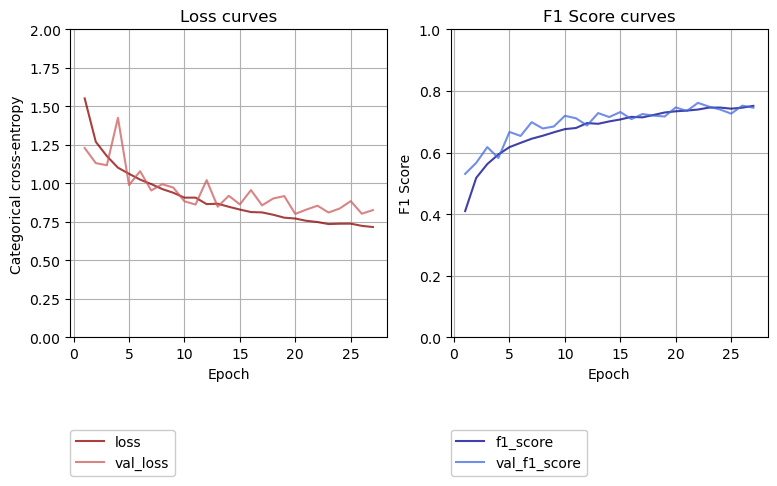

In [19]:
# Evaluate the performance metrics of the model
acc_01, f1_01, loss_01, val_acc_01, val_f1_01, val_loss_01 = get_metrics(history01)

# Plotting the results
plot_training_history(history01)

#### 9.1.2 Compile the model with Data Augmentation V2

In [20]:
# Create callbacks for the model
callbacks = create_model_callbacks("history02")
model02 = compile_model(model0)

# Train the model with callbacks
history02 = model02.fit(
    train_generator_16_2,
    validation_data=validation_generator_16,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
776/776 [==============================] - ETA: 0s - loss: 0.7202 - accuracy: 0.7588 - f1_score: 0.7538

c:\Users\Utilizador\anaconda3\envs\DL\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_f1_score improved from -inf to 0.76226, saving model to ./Callbacks\history02\best_model_acc.h5
776/776 [==============================] - 192s 245ms/step - loss: 0.7202 - accuracy: 0.7588 - f1_score: 0.7538 - val_loss: 0.8028 - val_accuracy: 0.7712 - val_f1_score: 0.7623 - lr: 0.0010
Epoch 2/50
776/776 [==============================] - ETA: 0s - loss: 0.6451 - accuracy: 0.7854 - f1_score: 0.7848
Epoch 2: val_f1_score improved from 0.76226 to 0.76853, saving model to ./Callbacks\history02\best_model_acc.h5
776/776 [==============================] - 189s 243ms/step - loss: 0.6451 - accuracy: 0.7854 - f1_score: 0.7848 - val_loss: 0.8173 - val_accuracy: 0.7771 - val_f1_score: 0.7685 - lr: 0.0010
Epoch 3/50
776/776 [==============================] - ETA: 0s - loss: 0.6171 - accuracy: 0.7959 - f1_score: 0.7903
Epoch 3: val_f1_score improved from 0.76853 to 0.78744, saving model to ./Callbacks\history02\best_model_acc.h5
776/776 [==============================] - 188s 242ms/st

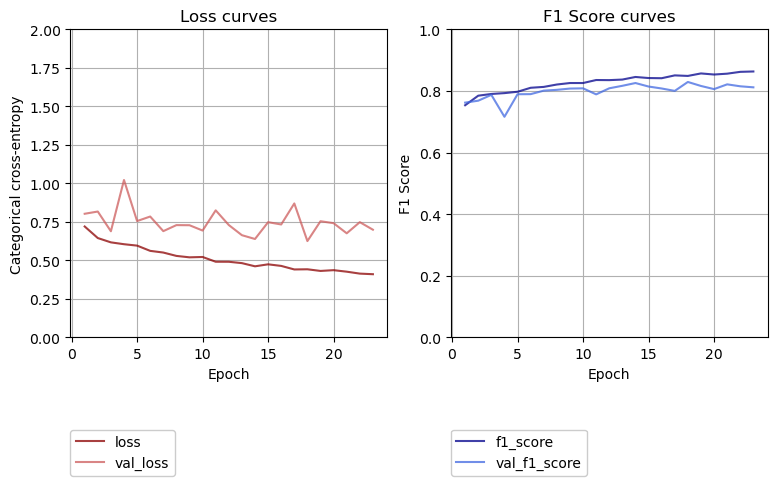

In [21]:
# Evaluate the performance metrics of the model
acc_02, f1_02, loss_02, val_acc_02, val_f1_02, val_loss_02 = get_metrics(history02)

# Plotting the results
plot_training_history(history02)

Conclusion: With this simple model, I've provided the model with two different types of data augmentation processes. From now on, for simplicity, I will proceed with the second data augmentation format as it provided better results.

### 9.2 Replicate the Data Augmentation V2 for batch sizes of 32 and 64

In [22]:
print("Batch size : 32")

train_generator_32 = train_datagen2.flow_from_directory(
    train_dir,
    target_size=img_size,  # Ensure all images are resized to 128x128
    batch_size=32,         # Number of images to return in each batch
    class_mode=label_mode  # Classes are returned in one-hot encoded format
)

validation_generator_32 = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=32,
    class_mode=label_mode
)

Batch size : 32
Found 12412 images belonging to 12 classes.
Found 1862 images belonging to 12 classes.


In [23]:
print("Batch size : 64")

# Assuming 'train_dir' is your training directory path
train_generator_64 = train_datagen2.flow_from_directory(
    train_dir,
    target_size=img_size,  # Ensure all images are resized to 128x128
    batch_size=64,         # Number of images to return in each batch
    class_mode=label_mode  # Classes are returned in one-hot encoded format
)

validation_generator_64 = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=64,
    class_mode=label_mode
)

Batch size : 64
Found 12412 images belonging to 12 classes.
Found 1862 images belonging to 12 classes.


### 9.3 Create Several Experimentation to inspect if the batch size and the usage of class weights influence the model performance

Now, having several batch sizes, I created a model to check if any of them outperforms the others. I will also tested if class_weights influence the imbalance class classification, keeping the simplest model possibble defined earlier.

#### 9.3.1 Batch size: 16, Class weights: yes

In [24]:
# Create callbacks for the model
callbacks = create_model_callbacks("history12")
model12 = compile_model(model0)

history12 = model12.fit(
    train_generator_16_2,
    epochs=50, 
    validation_data=validation_generator_16,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

Epoch 1/50
776/776 [==============================] - ETA: 0s - loss: 0.5644 - accuracy: 0.8320 - f1_score: 0.8312

c:\Users\Utilizador\anaconda3\envs\DL\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_f1_score improved from -inf to 0.74373, saving model to ./Callbacks\history12\best_model_acc.h5
776/776 [==============================] - 192s 245ms/step - loss: 0.5644 - accuracy: 0.8320 - f1_score: 0.8312 - val_loss: 0.8943 - val_accuracy: 0.7460 - val_f1_score: 0.7437 - lr: 0.0010
Epoch 2/50
776/776 [==============================] - ETA: 0s - loss: 0.5308 - accuracy: 0.8265 - f1_score: 0.8268
Epoch 2: val_f1_score improved from 0.74373 to 0.81033, saving model to ./Callbacks\history12\best_model_acc.h5
776/776 [==============================] - 190s 245ms/step - loss: 0.5308 - accuracy: 0.8265 - f1_score: 0.8268 - val_loss: 0.7784 - val_accuracy: 0.8072 - val_f1_score: 0.8103 - lr: 0.0010
Epoch 3/50
776/776 [==============================] - ETA: 0s - loss: 0.4534 - accuracy: 0.8501 - f1_score: 0.8505
Epoch 3: val_f1_score improved from 0.81033 to 0.81707, saving model to ./Callbacks\history12\best_model_acc.h5
776/776 [==============================] - 190s 245ms/st

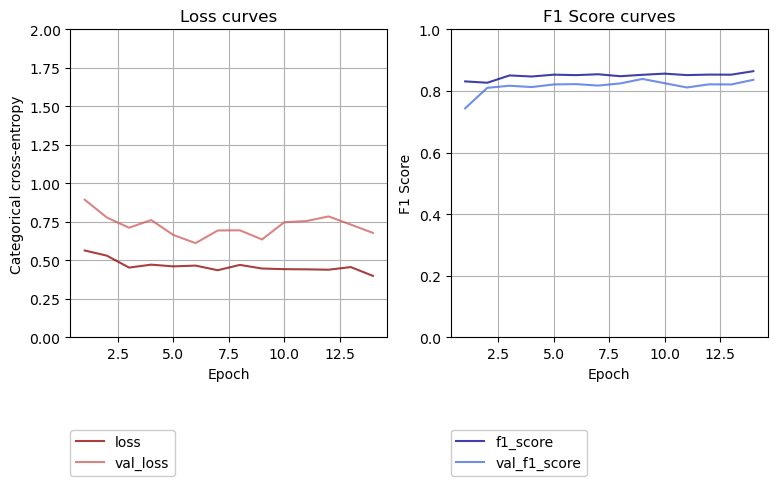

In [25]:
# Evaluate the performance metrics of the model
acc_12, f1_12, loss_12, val_acc_12, val_f1_12, val_loss_12 = get_metrics(history12)

# Plotting the results
plot_training_history(history12)

#### 9.3.2 Batch size: 32, Class weights: no

In [26]:
# Create callbacks for the model
callbacks = create_model_callbacks("history13")
model13 = compile_model(model0)

history13 = model13.fit(
    train_generator_32,
    epochs=50, 
    validation_data=validation_generator_32,
    callbacks=callbacks
)

Epoch 1/50
388/388 [==============================] - ETA: 0s - loss: 0.3208 - accuracy: 0.8907 - f1_score: 0.8925

c:\Users\Utilizador\anaconda3\envs\DL\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_f1_score improved from -inf to 0.81903, saving model to ./Callbacks\history13\best_model_acc.h5
388/388 [==============================] - 196s 499ms/step - loss: 0.3208 - accuracy: 0.8907 - f1_score: 0.8925 - val_loss: 0.8503 - val_accuracy: 0.8131 - val_f1_score: 0.8190 - lr: 0.0010
Epoch 2/50
388/388 [==============================] - ETA: 0s - loss: 0.3237 - accuracy: 0.8917 - f1_score: 0.8911
Epoch 2: val_f1_score improved from 0.81903 to 0.84479, saving model to ./Callbacks\history13\best_model_acc.h5
388/388 [==============================] - 193s 496ms/step - loss: 0.3237 - accuracy: 0.8917 - f1_score: 0.8911 - val_loss: 0.6823 - val_accuracy: 0.8410 - val_f1_score: 0.8448 - lr: 0.0010
Epoch 3/50
388/388 [==============================] - ETA: 0s - loss: 0.3094 - accuracy: 0.8914 - f1_score: 0.8946
Epoch 3: val_f1_score did not improve from 0.84479
388/388 [==============================] - 192s 495ms/step - loss: 0.3094 - accuracy: 0.8914 - f1_score: 0.8946 - val

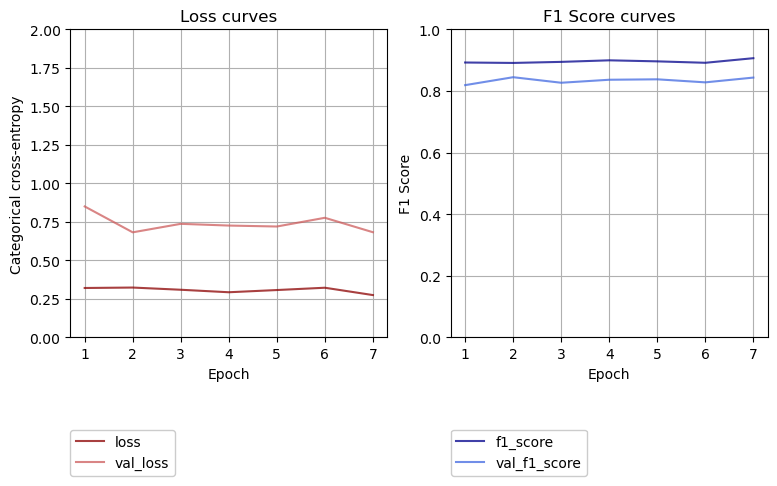

In [27]:
# Evaluate the performance metrics of the model
acc_13, f1_13, loss_13, val_acc_13, val_f1_13, val_loss_13 = get_metrics(history13)

# Plotting the results
plot_training_history(history13)

#### 9.3.3 Batch size: 32, Class weights: yes

In [28]:
# Create callbacks for the model
callbacks = create_model_callbacks("history14")
model14 = compile_model(model0)

history14 = model14.fit(
    train_generator_32,
    epochs=50, 
    validation_data=validation_generator_32,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

Epoch 1/50
388/388 [==============================] - ETA: 0s - loss: 0.3325 - accuracy: 0.8938 - f1_score: 0.8967

c:\Users\Utilizador\anaconda3\envs\DL\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_f1_score improved from -inf to 0.84000, saving model to ./Callbacks\history14\best_model_acc.h5
388/388 [==============================] - 196s 501ms/step - loss: 0.3325 - accuracy: 0.8938 - f1_score: 0.8967 - val_loss: 0.6742 - val_accuracy: 0.8373 - val_f1_score: 0.8400 - lr: 0.0010
Epoch 2/50
388/388 [==============================] - ETA: 0s - loss: 0.3429 - accuracy: 0.8868 - f1_score: 0.8869
Epoch 2: val_f1_score did not improve from 0.84000
388/388 [==============================] - 191s 493ms/step - loss: 0.3429 - accuracy: 0.8868 - f1_score: 0.8869 - val_loss: 0.7393 - val_accuracy: 0.8292 - val_f1_score: 0.8321 - lr: 0.0010
Epoch 3/50
388/388 [==============================] - ETA: 0s - loss: 0.3145 - accuracy: 0.8947 - f1_score: 0.8961
Epoch 3: val_f1_score did not improve from 0.84000
388/388 [==============================] - 192s 493ms/step - loss: 0.3145 - accuracy: 0.8947 - f1_score: 0.8961 - val_loss: 0.7353 - val_accuracy: 0.8340 - val_f1_score: 0.8383 -

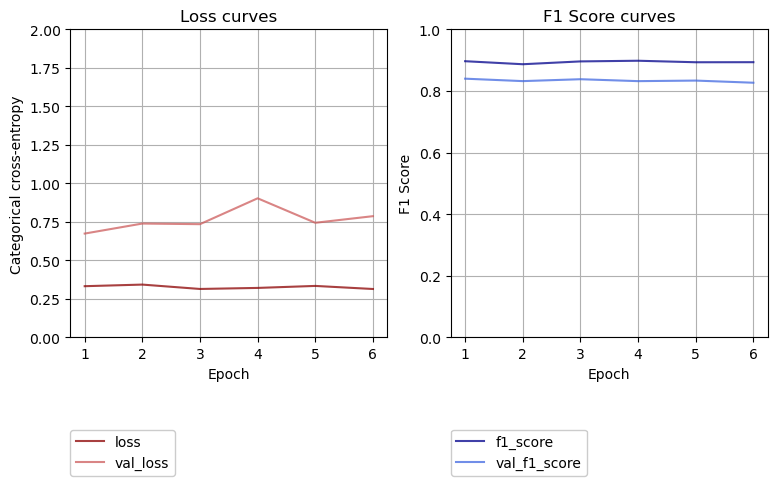

In [29]:
# Evaluate the performance metrics of the model
acc_14, f1_14, loss_14, val_acc_14, val_f1_14, val_loss_14 = get_metrics(history14)

# Plotting the results
plot_training_history(history14)

#### 9.3.4 Batch size: 64, Class weights: no

In [30]:
# Create callbacks for the model
callbacks = create_model_callbacks("history15")
model15 = compile_model(model0)

history15 = model15.fit(
    train_generator_64,
    epochs=50, 
    validation_data=validation_generator_64,
    callbacks=callbacks
)

Epoch 1/50
194/194 [==============================] - ETA: 0s - loss: 0.2562 - accuracy: 0.9127 - f1_score: 0.9134

c:\Users\Utilizador\anaconda3\envs\DL\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_f1_score improved from -inf to 0.84678, saving model to ./Callbacks\history15\best_model_acc.h5
194/194 [==============================] - 193s 981ms/step - loss: 0.2562 - accuracy: 0.9127 - f1_score: 0.9134 - val_loss: 0.7368 - val_accuracy: 0.8464 - val_f1_score: 0.8468 - lr: 0.0010
Epoch 2/50
194/194 [==============================] - ETA: 0s - loss: 0.2379 - accuracy: 0.9169 - f1_score: 0.9176
Epoch 2: val_f1_score did not improve from 0.84678
194/194 [==============================] - 197s 1s/step - loss: 0.2379 - accuracy: 0.9169 - f1_score: 0.9176 - val_loss: 0.8563 - val_accuracy: 0.8308 - val_f1_score: 0.8335 - lr: 0.0010
Epoch 3/50
194/194 [==============================] - ETA: 0s - loss: 0.2448 - accuracy: 0.9164 - f1_score: 0.9170
Epoch 3: val_f1_score improved from 0.84678 to 0.84903, saving model to ./Callbacks\history15\best_model_acc.h5
194/194 [==============================] - 189s 973ms/step - loss: 0.2448 - accuracy: 0.9164 - f1_score: 0.9170 - val_lo

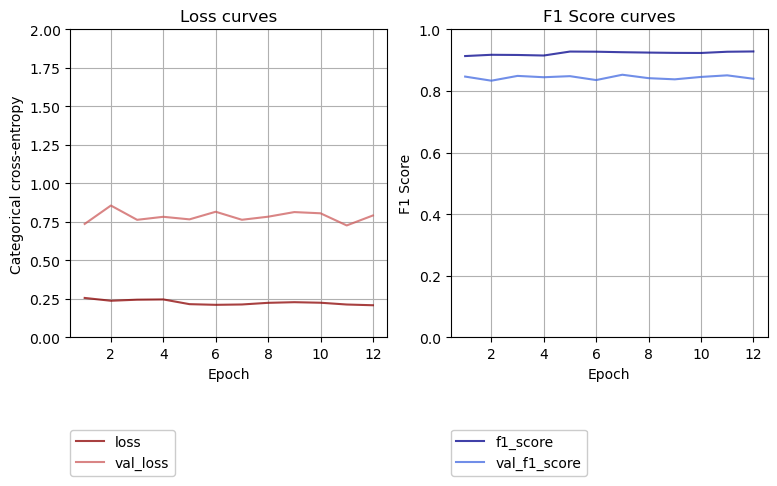

In [31]:
# Evaluate the performance metrics of the model
acc_15, f1_15, loss_15, val_acc_15, val_f1_15, val_loss_15 = get_metrics(history15)

# Plotting the results
plot_training_history(history15)

#### 9.3.5 Batch size: 64, Class weights: yes

In [32]:
# Create callbacks for the model
callbacks = create_model_callbacks("history16")
model16 = compile_model(model0)

history16 = model16.fit(
    train_generator_64,
    epochs=50, 
    validation_data=validation_generator_64,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

Epoch 1/50
194/194 [==============================] - ETA: 0s - loss: 0.2493 - accuracy: 0.9157 - f1_score: 0.9169

c:\Users\Utilizador\anaconda3\envs\DL\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_f1_score improved from -inf to 0.84156, saving model to ./Callbacks\history16\best_model_acc.h5
194/194 [==============================] - 187s 956ms/step - loss: 0.2493 - accuracy: 0.9157 - f1_score: 0.9169 - val_loss: 0.8703 - val_accuracy: 0.8394 - val_f1_score: 0.8416 - lr: 0.0010
Epoch 2/50
194/194 [==============================] - ETA: 0s - loss: 0.2462 - accuracy: 0.9187 - f1_score: 0.9200
Epoch 2: val_f1_score improved from 0.84156 to 0.85418, saving model to ./Callbacks\history16\best_model_acc.h5
194/194 [==============================] - 186s 956ms/step - loss: 0.2462 - accuracy: 0.9187 - f1_score: 0.9200 - val_loss: 0.7856 - val_accuracy: 0.8534 - val_f1_score: 0.8542 - lr: 0.0010
Epoch 3/50
194/194 [==============================] - ETA: 0s - loss: 0.2374 - accuracy: 0.9241 - f1_score: 0.9248
Epoch 3: val_f1_score did not improve from 0.85418
194/194 [==============================] - 184s 948ms/step - loss: 0.2374 - accuracy: 0.9241 - f1_score: 0.9248 - val

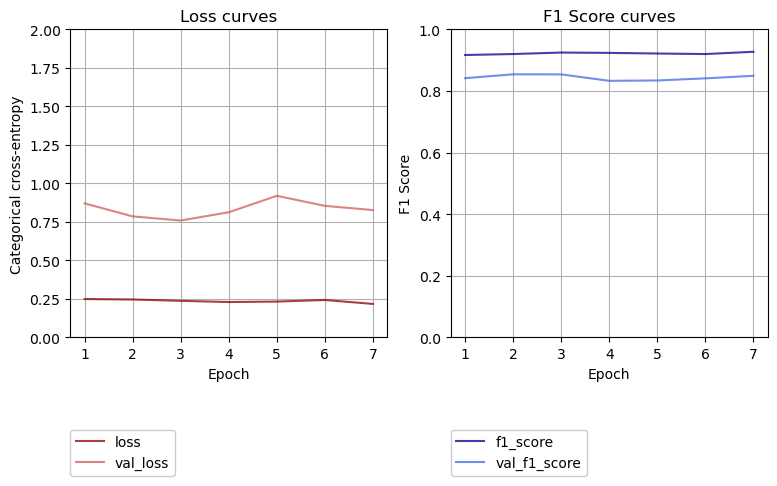

In [33]:
# Evaluate the performance metrics of the model
acc_16, f1_16, loss_16, val_acc_16, val_f1_16, val_loss_16 = get_metrics(history16)

# Plotting the results
plot_training_history(history16)

#### 9.3.6 Small comparison to check if any of the models outperforms the others

In [34]:
# Create a dictionary to store the information
data1 = {
    "Model": ["Model11", "Model12", "Model13", "Model14", "Model15", "Model16"],  
    "Accuracy": [acc_02, acc_12, acc_13, acc_14, acc_15, acc_16],  
    "F1_Score": [f1_02, f1_12, f1_13, f1_14, f1_15, f1_16],  
    "Loss": [loss_02, loss_12, loss_13, loss_14, loss_15, loss_16],  
    "Val_Accuracy": [val_acc_02, val_acc_12, val_acc_13, val_acc_14, val_acc_15, val_acc_16],  
    "Val_F1_Score": [val_f1_02, val_f1_12, val_f1_13, val_f1_14, val_f1_15, val_f1_16],  
    "Val_Loss": [val_loss_02, val_loss_12, val_loss_13, val_loss_14, val_loss_15, val_loss_16]  

print(pd.DataFrame(data1))

     Model  Accuracy  F1_Score      Loss  Val_Accuracy  Val_F1_Score  Val_Loss
0  Model11  0.862633  0.863376  0.410311      0.807734      0.811942  0.699266
1  Model12  0.863358  0.864322  0.399633      0.835124      0.836314  0.678634
2  Model13  0.905656  0.906524  0.274846      0.841568      0.843571  0.682948
3  Model14  0.896229  0.898249  0.321290      0.829216      0.832013  0.903221
4  Model15  0.926603  0.928385  0.208801      0.835661      0.839728  0.791729
5  Model16  0.925556  0.927338  0.217483      0.846939      0.849322  0.826885


Conclusion about the batch size: I concluded that a batch size of 16 is the worse on producing results, so I decided to proceed with the increase of the batch size to 32 or 64.

Conclusion about class_weights: unbelievably the models that use the class_weights dictionary don't have a better performance comparing to the ones that don't have. So I will decide to keep or not to keep it with further experiments.

### 9.4 CNN with incresed complexity
Besides increasing the general complexity from the first model and adding more neurons, in this model I added:
*   Batch Normalization (helps stabilize and accelerate the training of NN by normalizing the inputs of each layer, which can lead to faster convergence and better generalization)
*   Dropout (regularization technique that helps prevent overfitting by randomly dropping a fraction of neurons during training)


In [35]:
# Model definition with added complexity and batch normalization
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(3, 3),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),  
    BatchNormalization(),
    Dropout(0.2),

    Dense(train_generator_32.num_classes, activation='softmax')
])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 42, 42, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 40, 40, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 40, 40, 64)       256       
 hNormalization)                                                 
                                                      

#### 9.4.1 Compile the model with class weights and a batch size of 32

In [36]:
# Create callbacks for the model
callbacks = create_model_callbacks("history24")
model24 = compile_model(model2)

history24 = model24.fit(
    train_generator_32,
    epochs=50, 
    validation_data=validation_generator_32,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

Epoch 1/50
388/388 [==============================] - ETA: 0s - loss: 1.6449 - accuracy: 0.4688 - f1_score: 0.4138

c:\Users\Utilizador\anaconda3\envs\DL\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_f1_score improved from -inf to 0.28594, saving model to ./Callbacks\history24\best_model_acc.h5
388/388 [==============================] - 211s 534ms/step - loss: 1.6449 - accuracy: 0.4688 - f1_score: 0.4138 - val_loss: 1.7844 - val_accuracy: 0.4006 - val_f1_score: 0.2859 - lr: 0.0010
Epoch 2/50
388/388 [==============================] - ETA: 0s - loss: 1.3194 - accuracy: 0.5646 - f1_score: 0.5204
Epoch 2: val_f1_score improved from 0.28594 to 0.64306, saving model to ./Callbacks\history24\best_model_acc.h5
388/388 [==============================] - 206s 529ms/step - loss: 1.3194 - accuracy: 0.5646 - f1_score: 0.5204 - val_loss: 1.0203 - val_accuracy: 0.6692 - val_f1_score: 0.6431 - lr: 0.0010
Epoch 3/50
388/388 [==============================] - ETA: 0s - loss: 1.2063 - accuracy: 0.6001 - f1_score: 0.5674
Epoch 3: val_f1_score did not improve from 0.64306
388/388 [==============================] - 205s 526ms/step - loss: 1.2063 - accuracy: 0.6001 - f1_score: 0.5674 - val

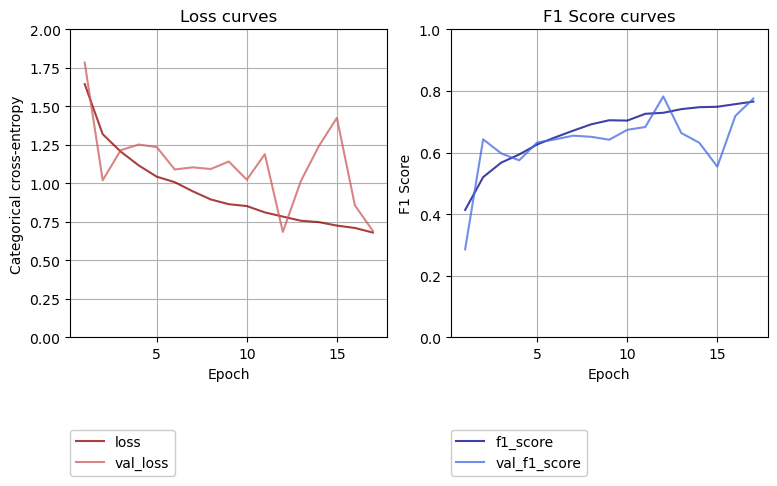

In [37]:
# Evaluate the performance metrics of the model
acc_24, f1_24, loss_24, val_acc_24, val_f1_24, val_loss_24 = get_metrics(history24)

# Plotting the results
plot_training_history(history24)

#### 9.4.2 Compile the model with class weights and a batch size of 64

In [38]:
# Create callbacks for the model
callbacks = create_model_callbacks("history26")
model26 = compile_model(model2)

history26 = model26.fit(
    train_generator_64,
    epochs=50, 
    validation_data=validation_generator_64,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

Epoch 1/50
194/194 [==============================] - ETA: 0s - loss: 0.5950 - accuracy: 0.7925 - f1_score: 0.7923

c:\Users\Utilizador\anaconda3\envs\DL\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_f1_score improved from -inf to 0.79627, saving model to ./Callbacks\history26\best_model_acc.h5
194/194 [==============================] - 210s 1s/step - loss: 0.5950 - accuracy: 0.7925 - f1_score: 0.7923 - val_loss: 0.6653 - val_accuracy: 0.7981 - val_f1_score: 0.7963 - lr: 0.0010
Epoch 2/50
194/194 [==============================] - ETA: 0s - loss: 0.5783 - accuracy: 0.7989 - f1_score: 0.7978
Epoch 2: val_f1_score improved from 0.79627 to 0.79738, saving model to ./Callbacks\history26\best_model_acc.h5
194/194 [==============================] - 202s 1s/step - loss: 0.5783 - accuracy: 0.7989 - f1_score: 0.7978 - val_loss: 0.6564 - val_accuracy: 0.7911 - val_f1_score: 0.7974 - lr: 0.0010
Epoch 3/50
194/194 [==============================] - ETA: 0s - loss: 0.5609 - accuracy: 0.8057 - f1_score: 0.8040
Epoch 3: val_f1_score did not improve from 0.79738
194/194 [==============================] - 202s 1s/step - loss: 0.5609 - accuracy: 0.8057 - f1_score: 0.8040 - val_loss: 0.

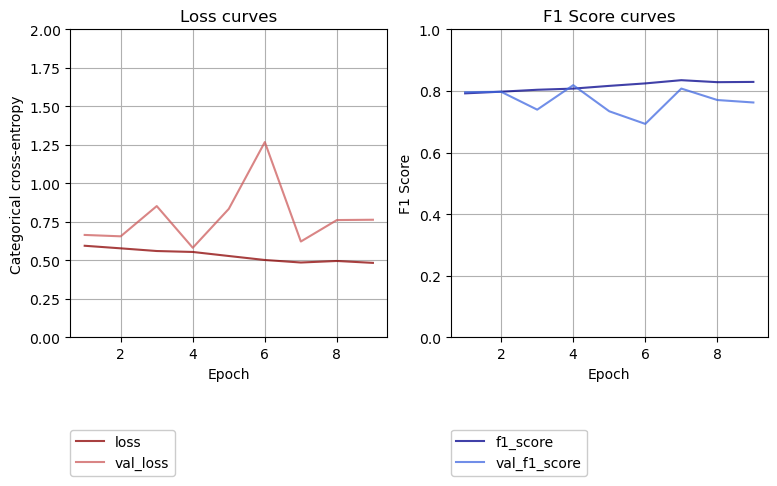

In [39]:
# Evaluate the performance metrics of the model
acc_26, f1_26, loss_26, val_acc_26, val_f1_26, val_loss_26 = get_metrics(history26)

# Plotting the results
plot_training_history(history26)

#### 9.4.3 Display the metrics for both versions of the linear model with increased complexity

In [40]:
data2 = {
    "Model": ["Model24", "Model26"],  
    "Accuracy": [acc_24, acc_26],  
    "F1_Score": [f1_24, f1_26],  
    "Loss": [loss_24, loss_26],  
    "Val_Accuracy": [val_acc_24, val_acc_26],  
    "Val_F1_Score": [val_f1_24, val_f1_26],  
    "Val_Loss": [val_loss_24, val_loss_26]  
}

# Print the updated data2
print(pd.DataFrame(data2))

     Model  Accuracy  F1_Score      Loss  Val_Accuracy  Val_F1_Score  Val_Loss
0  Model24  0.771914  0.765610  0.680691      0.776047      0.775545  0.691029
1  Model26  0.835079  0.835104  0.486281      0.803437      0.807909  0.622630


### 9.5 Deep CNN with Batch Normalization and Pooling Layers
The current model is a deeper and more complex network when compared to the previous one, with additional convolutional and pooling layers (increased  capacity to learn patterns in the data) and more neurons on the Dense layer. I also used 'same' padding in all convolutional layers (the spatial dimensions of the output feature maps are the same as the input dimensions).

However, this increased complexity leads to a higher computational cost and potential risk of overfitting.

In [41]:
model3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(3, 3),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(3, 3),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(train_generator_16_1.num_classes, activation='softmax')
])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_5 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                                                             
                                                      

#### 9.5.1 Compile the model with a batch of 32 and without class_weights

In [42]:
# Create callbacks for the model
callbacks = create_model_callbacks("history34")
model34 = compile_model(model3)

history34 = model34.fit(
    train_generator_32,
    epochs=50, 
    validation_data=validation_generator_32,
    callbacks=callbacks
)

Epoch 1/50
388/388 [==============================] - ETA: 0s - loss: 1.4880 - accuracy: 0.5349 - f1_score: 0.5141

c:\Users\Utilizador\anaconda3\envs\DL\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_f1_score improved from -inf to 0.32235, saving model to ./Callbacks\history34\best_model_acc.h5
388/388 [==============================] - 739s 2s/step - loss: 1.4880 - accuracy: 0.5349 - f1_score: 0.5141 - val_loss: 2.1312 - val_accuracy: 0.3754 - val_f1_score: 0.3223 - lr: 0.0010
Epoch 2/50
388/388 [==============================] - ETA: 0s - loss: 1.1590 - accuracy: 0.6192 - f1_score: 0.6087
Epoch 2: val_f1_score improved from 0.32235 to 0.43306, saving model to ./Callbacks\history34\best_model_acc.h5
388/388 [==============================] - 736s 2s/step - loss: 1.1590 - accuracy: 0.6192 - f1_score: 0.6087 - val_loss: 2.1741 - val_accuracy: 0.4168 - val_f1_score: 0.4331 - lr: 0.0010
Epoch 3/50
388/388 [==============================] - ETA: 0s - loss: 1.0111 - accuracy: 0.6668 - f1_score: 0.6561
Epoch 3: val_f1_score improved from 0.43306 to 0.57400, saving model to ./Callbacks\history34\best_model_acc.h5
388/388 [==============================] - 734s 2s/step - loss

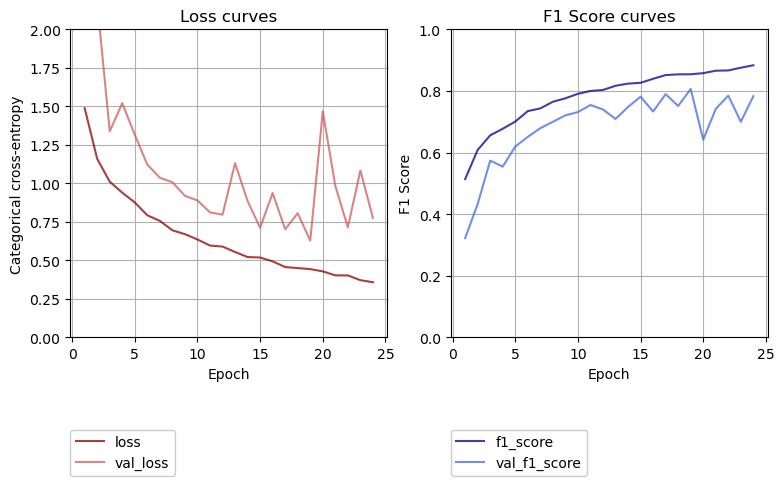

In [43]:
# Evaluate the performance metrics of the model
acc_34, f1_34, loss_34, val_acc_34, val_f1_34, val_loss_34 = get_metrics(history34)

# Plotting the results
plot_training_history(history34)

#### 9.5.2 Compile the model with a batch of 64 and without class_weights

In [44]:
# Create callbacks for the model
callbacks = create_model_callbacks("history36")
model36 = compile_model(model3)

history36 = model36.fit(
    train_generator_64,
    epochs=50, 
    validation_data=validation_generator_64,
    callbacks=callbacks
)

Epoch 1/50
194/194 [==============================] - ETA: 0s - loss: 0.2935 - accuracy: 0.9018 - f1_score: 0.9015

c:\Users\Utilizador\anaconda3\envs\DL\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_f1_score improved from -inf to 0.82697, saving model to ./Callbacks\history36\best_model_acc.h5
194/194 [==============================] - 739s 4s/step - loss: 0.2935 - accuracy: 0.9018 - f1_score: 0.9015 - val_loss: 0.5748 - val_accuracy: 0.8255 - val_f1_score: 0.8270 - lr: 0.0010
Epoch 2/50
194/194 [==============================] - ETA: 0s - loss: 0.2710 - accuracy: 0.9090 - f1_score: 0.9099
Epoch 2: val_f1_score improved from 0.82697 to 0.88274, saving model to ./Callbacks\history36\best_model_acc.h5
194/194 [==============================] - 727s 4s/step - loss: 0.2710 - accuracy: 0.9090 - f1_score: 0.9099 - val_loss: 0.4040 - val_accuracy: 0.8802 - val_f1_score: 0.8827 - lr: 0.0010
Epoch 3/50
194/194 [==============================] - ETA: 0s - loss: 0.2669 - accuracy: 0.9111 - f1_score: 0.9109
Epoch 3: val_f1_score did not improve from 0.88274
194/194 [==============================] - 726s 4s/step - loss: 0.2669 - accuracy: 0.9111 - f1_score: 0.9109 - val_loss: 0.

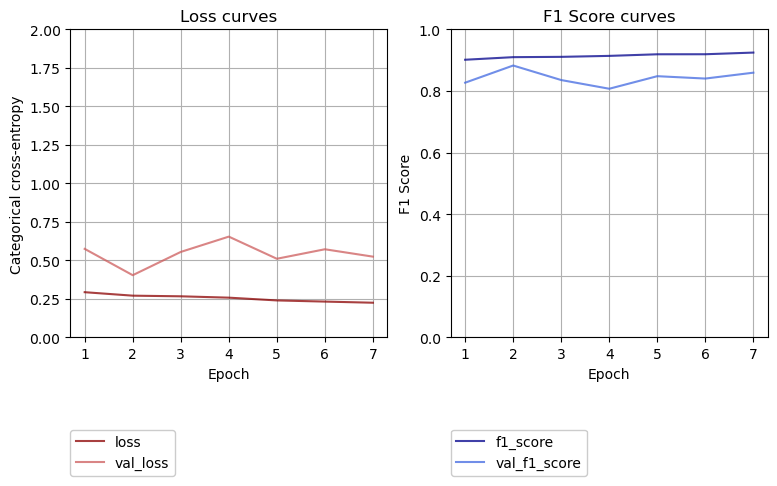

In [45]:
# Evaluate the performance metrics of the model
acc_36, f1_36, loss_36, val_acc_36, val_f1_36, val_loss_36 = get_metrics(history36)

# Plotting the results
plot_training_history(history36)

#### 9.5.3 Display the metrics for both models

In [46]:
data3 = {
    "Model": ["Model34", "Model36"], 
    "Accuracy": [acc_34, acc_36],  
    "F1_Score": [f1_34, f1_36],  
    "Loss": [loss_34, loss_36],  
    "Val_Accuracy": [val_acc_34, val_acc_36],  
    "Val_F1_Score": [val_f1_34, val_f1_36],  
    "Val_Loss": [val_loss_34, val_loss_36]  
}

# Print the updated data3
print(pd.DataFrame(data3))

     Model  Accuracy  F1_Score      Loss  Val_Accuracy  Val_F1_Score  Val_Loss
0  Model34  0.883097  0.883559  0.358080      0.776584      0.783149  0.775703
1  Model36  0.924025  0.924743  0.225175      0.854458      0.859482  0.524418


### 9.6 Deep CNN with Regularization Techniques
The main difference of this model is the incorporation of L2 regularization in the first dense layer to control overfitting. I also kept a dropout regularization to further prevent co-adaptation of neurons during training. 

In [47]:
model4 = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
    BatchNormalization(),
    MaxPooling2D(3, 3),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(train_generator_64.num_classes, activation='softmax')
])

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization_11 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 42, 42, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 42, 42, 128)       73856     
                                                                 
 batch_normalization_12 (Bat  (None, 42, 42, 128)      512       
 chNormalization)                                                
                                                      

#### 9.6.1 Compile the model with a batch size of 64 and no class weights

In [48]:
# Create callbacks for the model
callbacks = create_model_callbacks("history46")
model46 = compile_model(model4)

history46 = model46.fit(
    train_generator_64,
    epochs=50, 
    validation_data=validation_generator_64,
    callbacks=callbacks
)

Epoch 1/50
194/194 [==============================] - ETA: 0s - loss: 1.6940 - accuracy: 0.5574 - f1_score: 0.5332

c:\Users\Utilizador\anaconda3\envs\DL\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_f1_score improved from -inf to 0.33186, saving model to ./Callbacks\history46\best_model_acc.h5
194/194 [==============================] - 378s 2s/step - loss: 1.6940 - accuracy: 0.5574 - f1_score: 0.5332 - val_loss: 2.7860 - val_accuracy: 0.3990 - val_f1_score: 0.3319 - lr: 0.0010
Epoch 2/50
194/194 [==============================] - ETA: 0s - loss: 1.3776 - accuracy: 0.6329 - f1_score: 0.6151
Epoch 2: val_f1_score improved from 0.33186 to 0.51384, saving model to ./Callbacks\history46\best_model_acc.h5
194/194 [==============================] - 371s 2s/step - loss: 1.3776 - accuracy: 0.6329 - f1_score: 0.6151 - val_loss: 1.6789 - val_accuracy: 0.5269 - val_f1_score: 0.5138 - lr: 0.0010
Epoch 3/50
194/194 [==============================] - ETA: 0s - loss: 1.2351 - accuracy: 0.6669 - f1_score: 0.6516
Epoch 3: val_f1_score improved from 0.51384 to 0.65761, saving model to ./Callbacks\history46\best_model_acc.h5
194/194 [==============================] - 370s 2s/step - loss

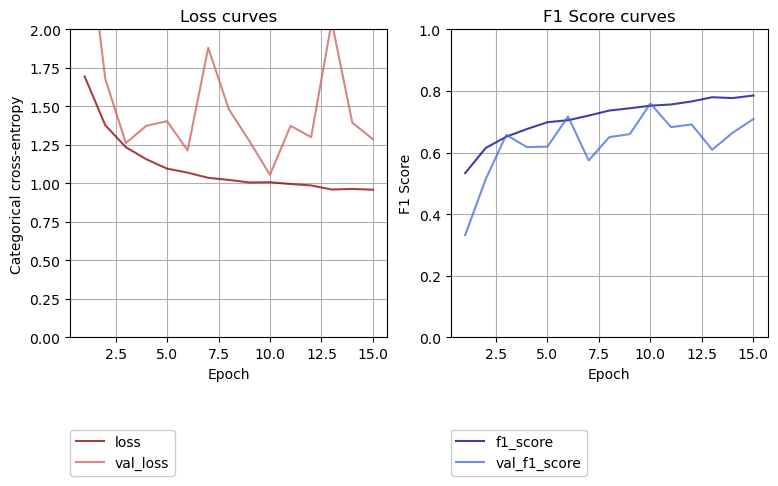

In [49]:
# Plotting the results
plot_training_history(history46)

### 9.7 Fully Regularized CNN
This model applies regularization more extensively, potentially leading to greater control over model complexity and better generalization (L2 regularization on both the kernel and bias weights in the dense layers, instead of applying it only to the kernel weights in the first dense layer). This model also encompasses some changes in the regularization strength setting it to 1e-5 for kernel and 1e-4 bias weights, while in the previous one it's set to 1e-3 for kernel weights only (this can impact how much the model is penalized for large weights, affecting the balance between fitting the training data and preventing overfitting).


In [50]:
model5 = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(3, 3),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(units=128, activation='relu', kernel_regularizer=regularizers.L2(1e-5),
                               bias_regularizer=regularizers.L2(1e-4)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(train_generator_64.num_classes, activation='softmax', kernel_regularizer=regularizers.L2(1e-5),
                               bias_regularizer=regularizers.L2(1e-4))
])

model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 126, 126, 64)      1792      
                                                                 
 batch_normalization_15 (Bat  (None, 126, 126, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 42, 42, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 40, 40, 128)       73856     
                                                                 
 batch_normalization_16 (Bat  (None, 40, 40, 128)      512       
 chNormalization)                                                
                                                      

#### 9.7.1 Compile the model with a batch size of 64 and without class weights

In [51]:
# Create callbacks for the model
callbacks = create_model_callbacks("history56")
model56 = compile_model(model5)

history56 = model56.fit(
    train_generator_64,
    epochs=50, 
    validation_data=validation_generator_64,
    callbacks=callbacks
)

Epoch 1/50
194/194 [==============================] - ETA: 0s - loss: 1.4091 - accuracy: 0.5547 - f1_score: 0.5337

c:\Users\Utilizador\anaconda3\envs\DL\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_f1_score improved from -inf to 0.13646, saving model to ./Callbacks\history56\best_model_acc.h5
194/194 [==============================] - 332s 2s/step - loss: 1.4091 - accuracy: 0.5547 - f1_score: 0.5337 - val_loss: 2.8294 - val_accuracy: 0.1933 - val_f1_score: 0.1365 - lr: 0.0010
Epoch 2/50
194/194 [==============================] - ETA: 0s - loss: 1.0975 - accuracy: 0.6403 - f1_score: 0.6232
Epoch 2: val_f1_score improved from 0.13646 to 0.46659, saving model to ./Callbacks\history56\best_model_acc.h5
194/194 [==============================] - 328s 2s/step - loss: 1.0975 - accuracy: 0.6403 - f1_score: 0.6232 - val_loss: 1.5128 - val_accuracy: 0.5215 - val_f1_score: 0.4666 - lr: 0.0010
Epoch 3/50
194/194 [==============================] - ETA: 0s - loss: 0.9901 - accuracy: 0.6713 - f1_score: 0.6600
Epoch 3: val_f1_score improved from 0.46659 to 0.57939, saving model to ./Callbacks\history56\best_model_acc.h5
194/194 [==============================] - 326s 2s/step - loss

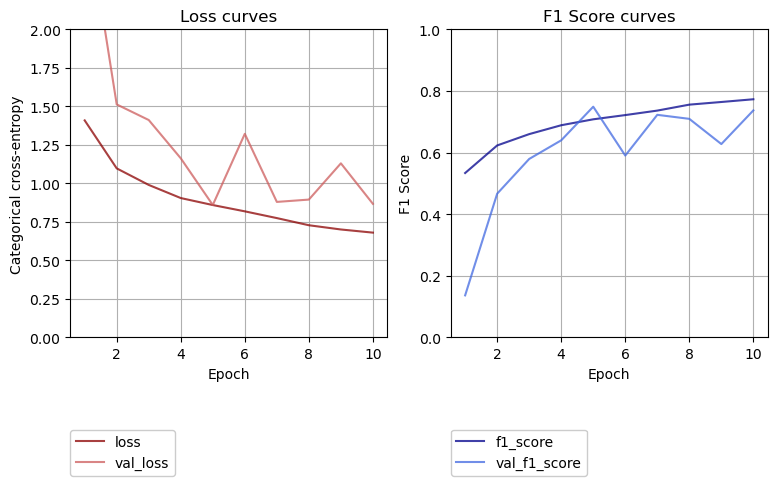

In [52]:
# Plotting the results
plot_training_history(history56)